# Определение варианта КП

In [2]:
from pygost import gost34112012256

data = bytes(" Дубровин Дмитрий Константинович ", encoding="utf-8")
hash_value = gost34112012256.new(data).digest(); 

version = hash_value[-1] & 0x0F
print(version)

3


### Алгоритм Blake без модификаций

In [2]:
import struct, binascii, copy
from ctypes import *

MASK8BITS   = 0xff
MASK16BITS  = 0xffff
MASK32BITS  = 0xffffffff
MASK48BITS  = 0xffffffffffff
MASK64BITS  = 0xffffffffffffffff

class BLAKE2(object):
    sigma = [
        [  0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15 ],
        [ 14,10, 4, 8, 9,15,13, 6, 1,12, 0, 2,11, 7, 5, 3 ],
        [ 11, 8,12, 0, 5, 2,15,13,10,14, 3, 6, 7, 1, 9, 4 ],
        [  7, 9, 3, 1,13,12,11,14, 2, 6, 5,10, 4, 0,15, 8 ],
        [  9, 0, 5, 7, 2, 4,10,15,14, 1,11,12, 6, 8, 3,13 ],
        [  2,12, 6,10, 0,11, 8, 3, 4,13, 7, 5,15,14, 1, 9 ],
        [ 12, 5, 1,15,14,13, 4,10, 0, 7, 6, 3, 9, 2, 8,11 ],
        [ 13,11, 7,14,12, 1, 3, 9, 5, 0,15, 4, 8, 6, 2,10 ],
        [  6,15,14, 9,11, 3, 0, 8,12, 2,13, 7, 1, 4,10, 5 ],
        [ 10, 2, 8, 4, 7, 6, 1, 5,15,11, 9,14, 3,12,13 ,0 ],
        [  0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15 ],
        [ 14,10, 4, 8, 9,15,13, 6, 1,12, 0, 2,11, 7, 5, 3 ]
    ]
    
    def __init__(self, digest_size=0, **args):
        raise Exception('base class instantiation')

    def _init(self, key=b''):
        
        assert len(key) <= self.KEYBYTES

        P = self.PARAMS()
        P.F.digest_size      = self.digest_size
        P.F.key_length       = len(key)
        P.F.fanout           = self.fanout
        P.F.depth            = self.depth
        P.F.leaf_size        = self.leaf_size
        P.F.node_offset_lo   = self.node_offset & MASK32BITS
        P.F.node_offset_hi   = self.node_offset >> 32
        P.F.node_depth       = self.node_depth
        P.F.inner_size       = self.inner_size
        P.F.salt   = (self.salt + 
                (chr(0).encode())*(self.SALTBYTES-len(self.salt)))
        P.F.person = (self.person + 
                (chr(0).encode())*(self.PERSONALBYTES-len(self.person)))
        
        self.h               = [self.IV[i] ^ P.W[i] for i in range(8)]
        
        self.totbytes        = 0
        self.t               = [0]*2
        self.f               = [0]*2
        self.buflen          = 0
        self.buf             = b''
        self.finalized       = False
        self.block_size      = self.BLOCKBYTES
        
        if key:
            block = key + (chr(0).encode())*(self.BLOCKBYTES-len(key))
            self.update(block)
        
        if self.data:
            self.update(self.data)
    
    def _compress(self, block):

        MASKBITS  = self.MASKBITS
        WORDBITS  = self.WORDBITS
        WORDBYTES = self.WORDBYTES
        IV        = self.IV
        sigma     = self.sigma
        ROT1      = self.ROT1
        ROT2      = self.ROT2
        ROT3      = self.ROT3
        ROT4      = self.ROT4
        WB_ROT1   = WORDBITS - ROT1
        WB_ROT2   = WORDBITS - ROT2
        WB_ROT3   = WORDBITS - ROT3
        WB_ROT4   = WORDBITS - ROT4
        
        m = struct.unpack_from('<16%s' % self.WORDFMT, bytes(block))
        
        v = [0]*16
        v[ 0: 8] = self.h
        v[ 8:12] = IV[:4]
        v[12] = self.t[0] ^ IV[4]
        v[13] = self.t[1] ^ IV[5]
        v[14] = self.f[0] ^ IV[6]
        v[15] = self.f[1] ^ IV[7]

        def G(a, b, c, d):
            va = v[a]
            vb = v[b]
            vc = v[c]
            vd = v[d]
            va = (va + vb + msri2)              & MASKBITS
            w = vd ^ va
            vd = (w >> ROT1) | (w << (WB_ROT1)) & MASKBITS
            vc = (vc + vd)                      & MASKBITS
            w = vb ^ vc
            vb = (w >> ROT2) | (w << (WB_ROT2)) & MASKBITS
            va = (va + vb + msri21)             & MASKBITS
            w = vd ^ va
            vd = (w >> ROT3) | (w << (WB_ROT3)) & MASKBITS
            vc = (vc + vd)                      & MASKBITS
            w = vb ^ vc
            vb = (w >> ROT4) | (w << (WB_ROT4)) & MASKBITS
            v[a] = va
            v[b] = vb
            v[c] = vc
            v[d] = vd

        for r in range(self.ROUNDS):
            sr = sigma[r]
            msri2  = m[sr[0]]
            msri21 = m[sr[1]]
            G( 0,  4,  8, 12)
            msri2  = m[sr[2]]
            msri21 = m[sr[3]]
            G( 1,  5,  9, 13)
            msri2  = m[sr[4]]
            msri21 = m[sr[5]]
            G( 2,  6, 10, 14)
            msri2  = m[sr[6]]
            msri21 = m[sr[7]]
            G( 3,  7, 11, 15)
            msri2  = m[sr[8]]
            msri21 = m[sr[9]]
            G( 0,  5, 10, 15)
            msri2  = m[sr[10]]
            msri21 = m[sr[11]]
            G( 1,  6, 11, 12)
            msri2  = m[sr[12]]
            msri21 = m[sr[13]]
            G( 2,  7,  8, 13)
            msri2  = m[sr[14]]
            msri21 = m[sr[15]]
            G( 3,  4,  9, 14)

        self.h = [self.h[i] ^ v[i] ^ v[i+8] for i in range(8)]
    
    def update(self, data):
        
        assert self.finalized == False
        
        BLOCKBYTES = self.BLOCKBYTES
        
        datalen = len(data)
        dataptr = 0
        while True:
            if len(self.buf) > BLOCKBYTES:
                self._increment_counter(BLOCKBYTES)
                self._compress(self.buf[:BLOCKBYTES])
                self.buf = self.buf[BLOCKBYTES:]
            if dataptr < datalen:
                self.buf += data[dataptr:dataptr + BLOCKBYTES]
                dataptr += BLOCKBYTES
            else:
                break
    
    def final(self):
        if not self.finalized and len(self.buf):
            self._increment_counter(len(self.buf))
            self._set_lastblock()
            self.buf += (chr(0).encode())*(self.BLOCKBYTES - len(self.buf))
            self._compress(self.buf)
            self.buf = b''
        self.digest_ = struct.pack('<8%s' % self.WORDFMT, *tuple(self.h))
        self.finalized = True
        return self.digest_[:self.digest_size]
    
    digest = final
    
    def hexdigest(self):
        return binascii.hexlify(self.final()).decode()
    
    def _set_lastblock(self):
        if self.last_node:
            self.f[1] = self.MASKBITS
        self.f[0] = self.MASKBITS
    
    def _increment_counter(self, numbytes):
        self.totbytes += numbytes
        self.t[0] = self.totbytes & self.MASKBITS
        self.t[1] = self.totbytes >> self.WORDBITS

    def copy(self):
        return copy.deepcopy(self)


class BLAKE2s(BLAKE2):
    
    WORDBITS      = 32
    WORDBYTES     = 4
    MASKBITS      = MASK32BITS
    WORDFMT       = 'L' 
    
    #ROUNDS        = 10
    BLOCKBYTES    = 64
    OUTBYTES      = 32
    KEYBYTES      = 32
    SALTBYTES     = 8
    PERSONALBYTES = 8
    
    IV = [
        0x6a09e667, 0xbb67ae85,
        0x3c6ef372, 0xa54ff53a,
        0x510e527f, 0x9b05688c,
        0x1f83d9ab, 0x5be0cd19
    ]
    
    ROT1 = 16
    ROT2 = 12
    ROT3 = 8
    ROT4 = 7

    
    def __init__(self, data=b'', digest_size=32, key=b'', 
                       salt=b'', person=b'', fanout=1, depth=1, 
                       leaf_size=0, node_offset=0, node_depth=0, 
                       inner_size=0, last_node=False, round=10):
        
        self.ROUNDS = round
        assert 1 <= digest_size <= self.OUTBYTES
        assert len(key)         <= self.KEYBYTES
        assert len(salt)        <= self.SALTBYTES
        assert len(person)      <= self.PERSONALBYTES
        assert 0 <= fanout      <= MASK8BITS
        assert 0 <= depth       <= MASK8BITS
        assert 0 <= leaf_size   <= MASK32BITS
        assert 0 <= node_offset <= MASK48BITS
        assert 0 <= node_depth  <= MASK8BITS
        assert 0 <= inner_size  <= MASK8BITS
        
        class ParamFields32(LittleEndianStructure):
            pass
        
        ParamFields32.SALTBYTES     = self.SALTBYTES
        ParamFields32.PERSONALBYTES = self.PERSONALBYTES
        ParamFields32._fields_ = [
                    ("digest_size",    c_ubyte),
                    ("key_length",     c_ubyte),
                    ("fanout",         c_ubyte),
                    ("depth",          c_ubyte),
                    ("leaf_size",      c_uint32),
                    ("node_offset_lo", c_uint32),
                    ("node_offset_hi", c_uint16),
                    ("node_depth",     c_ubyte),
                    ("inner_size",     c_ubyte),
                    ("salt",           c_char * self.SALTBYTES),
                    ("person",         c_char * self.PERSONALBYTES),
                   ]
        
        class Params32(Union):
            _fields_ = [("F", ParamFields32),
                        ("W", c_uint32 * 8),
                       ]
        self.PARAMS = Params32
        self.digest_size  = digest_size
        self.data         = data
        self.salt         = salt
        self.person       = person
        self.fanout       = fanout
        self.depth        = depth
        self.leaf_size    = leaf_size
        self.node_offset  = node_offset
        self.node_depth   = node_depth
        self.inner_size   = inner_size
        self.last_node    = last_node
                                  
        self._init(key=key)

## Тестирование работы

In [4]:
def demo_sk():
    data = b'test text'
    b2 = BLAKE2s()
    b2.update(data)
    digest = b2.final()
    print(b2.hexdigest())
    
demo_sk()

7fc8735bc290d0b6a03dbd4048e1cf9b2497fd1043f87254c63f2d7a57c5b9fe


Проведем анализ различия битов в результате работы алгоритма -> число раундов от 1 до 10. Пострим график различия битов после определенного числа раундов.

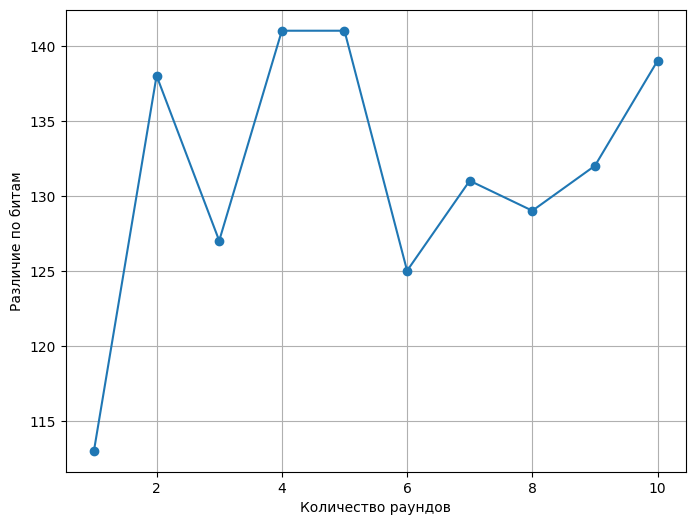

In [5]:
import matplotlib.pyplot as plt

def first(round):
    data = b'aaaaabbbccc'
    b2 = BLAKE2s(round=round)
    b2.update(data)
    digest = b2.final()
    return b2.hexdigest()
def second(round):
    data = b'baaaabbbccc'
    b2 = BLAKE2s(round=round)
    b2.update(data)
    digest = b2.final()
    return b2.hexdigest()

def bit_difference(hash1, hash2):
    difference = 0
    for i in range(len(hash1)):
        byte1 = int(hash1[i], 16)
        byte2 = int(hash2[i], 16)
        xor_result = byte1 ^ byte2
        difference += bin(xor_result).count('1')
    return difference


rounds = []
differences = []

for i in range(1, 11):
    f = first(i)
    s = second(i)
    rounds.append(i)
    differences.append(bit_difference(f, s))

plt.figure(figsize=(8, 6))
plt.plot(rounds, differences, marker='o')
plt.xlabel('Количество раундов')
plt.ylabel('Различие по битам')
plt.grid(True)
plt.show()